# GIS GZ – Übung 6: Geoprocessing mit Netzwerken – Critical Thinking <span style="color:red">(Musterlösung)</span>

## Inhalt

Das Ziel dieses Teils der Übung ist es, Ihr kritisches Denken zu schärfen.

## Aufgabe 1

Der Code in der folgenden Zelle ist bereits aus Teil 2 bekannt:

In [1]:
import rasterio
from shapely.geometry import LineString
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot as rplot
import os

default_lattice = [[((0, 0), 1.0 / 2.0), (( 0,  1), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), ((-1,  0), 1.0 / 2.0)],
                   [((0, 0), 1.0 / 2.0), (( 0, -1), 1.0 / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1,  1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), ((-1, -1), np.sqrt(2) / 2.0)],
                   [((0, 0), np.sqrt(2) / 2.0), (( 1, -1), np.sqrt(2) / 2.0)]
                  ]


def calc_least_cost_path(path, band=1, source_coord=(0, 0), target_coord=(0, 0), matrix=default_lattice):
    """
    Create a graph with the weighted edges based on the cost surface and compute the least cost path
    
    Args:
        path (str): Path to the input raster file that represents the cost surface
        band (int): The band of the raster file that contains the cost values
        source_coord (tuple): The coordinate pair of the source point, given in the same CRS as the cost surface
        target_coord (tuple): The coordinate pair of the target point, given in the same CRS as the cost surface
        matrix (list): The lattice (search kernel) used to determine the least cost neighbors
        
    
    Returns:
        The total costs and a LineString object of the least cost path
    """

    # Open Raster
    with rasterio.open(path) as src:

        fwd = src.transform
        data = src.read(band)
        NODATA = src.meta['nodata']

        print("-- Create Graph --")
        G = nx.DiGraph()


        # Create edges
        _edges = []

        for i in range(src.width):
            for j in range(src.height):

                for edge in matrix:

                    (start_i, start_j), _ = edge[0]
                    start_node = (start_i + i, start_j + j)

                    (end_i, end_j), _ = edge[-1]
                    end_node = (end_i + i, end_j + j)

                    # We only consider edges within the study area that have a value
                    if ((0 <= start_node[0] < src.width and 0 <= start_node[1] < src.height) and
                            (0 <= end_node[0] < src.width and 0 <= end_node[1] < src.height) and
                            (not data[j, i] == NODATA)):

                        # Calculate cost of edge
                        cost = 0.0
                        has_nodata = False
                        for k in edge:
                            (k_i, k_j), w_k = k
                            d = data[k_j + j, k_i + i]
                            if d == NODATA:
                                has_nodata = True
                                break
                            cost += d * w_k

                        if not has_nodata:
                            _edges.append((start_node, end_node, cost))

        G.add_weighted_edges_from(_edges)

        print("")
        print("\t Created graph with:")
        print("\t # Vertex: {}".format(G.number_of_nodes()))
        print("\t # Edges: {} ".format(G.number_of_edges()))
        print("")

        # Find shortest path and return total cost and LineString of found path
        print("-- Find shortest path --")
        source_node = tuple(map(int, ~fwd * source_coord))
        target_node = tuple(map(int, ~fwd * target_coord))

        tot_cost, path = nx.single_source_dijkstra(G,
                                                   source=source_node,
                                                   target=target_node,
                                                   weight='weight')

        _coords = []
        for p in path:
            # We add 0.5 to p to get coordinate of middle of corresponding cell
            x, y = fwd * (p[0] + 0.5, p[1] + 0.5)
            _coords.append((x, y))

        ls = LineString(_coords)

        print("")
        print("\t Found path with:")
        print("\t\t # Path costs: {}".format(tot_cost))
        print("\t\t # Path length: {} ".format(ls.length))
        print("")

    return tot_cost, ls


def plot_result(lss, cost_surface=None):
    """
    Plots the LineString object by using Rasterio plot
    
    Args:
        ls (LineString): The LineString object of the least cost path
        cost_surface (str): The path to the cost surface that should be displayed
        cost_surface_polygon (Polygon): The Polygon object that should be displayed
        restricted_area (str): The path to the restricted area that should be displayed

    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if cost_surface is not None:
        with rasterio.open(cost_surface) as src:
            rplot.show(src, ax=ax, zorder=10)

    if not isinstance(lss, list):
        lss = [lss]

    for ls in lss:
        x, y = ls.xy
        ax.plot(x, y,
                color='k',
                alpha=0.7,
                linewidth=3,
                solid_capstyle='round',
                zorder=1000)

    plt.show()
    return

Wir berechnen nun den Least Cost Path für einen "synthetischen" Test case (`"synthetic.tif"`). Wir berechnen den Least Cost Path von Start nach Ziel, sowie von Ziel nach Start. Wie Sie selber überprüfen können, gibt der Algorithmus verschiedene Least Cost Paths zurück.

* **Wie können Sie sich dieses Phänomen algorithmisch erkären?**
* **Was bedeutet dies für Sie, falls Sie in der Praxis jemals ein LCP Problem berechnen müssen?**

**<span style="color:orange">Grundsätzlich beruht das Problem darauf, dass die Kosten für zwei Wege exakt gleich sind. Das geschieht dann häufig, wenn es homogene Gebiete auf der Kostenoberfläche gibt. Häufig wird der Algorithmus so implementiert, dass in solchen Fällen die erste Lösung genommen wird (wenn geprüft wird, ob die Kosten für einen anderen Weg _geringer_ sind, lautet die Antwort in diesem Fall _nein_, da die Kosten gleich sind). Welches die _erste_ Lösung ist, hängt von der Iteration durch Ihr Suchmuster ab. </span>**

**<span style="color:orange">Eine einfache Lösung liegt darin, den least cost path für den Hin- und für den Rückweg zu bestimmen. Dann sieht man, in welchen Gebieten es mehrere optimale Lösungen gibt. </span>**
    
**<span style="color:orange">Eine andere (und noch nicht häufig umgesetzte) Lösung liegt darin, den Algorithmus nicht abzubrechen, nachdem der Endpunkt erreicht wurde. Alternativ könnte man (analog zum _k shortest path_) im Voraus definieren, wie viele weitere suboptimale Pfade gefunden werden sollen (oder man definiert einen Kostenbereich, bis zu welchem Mehrkosten in Kauf genommen werden). Man könnte dann den Pfad mit den zweit-, dritt- oder viertgeringsten Kosten etc. ermitteln und nebeneinander vergleichen. Interessant wäre es in diesem Fall, eine _Kernel Density Estimation_ der erhaltenen Pfade durchzuführen. Diese würde dann angeben, wie wahrscheinlich es ist, dass sich eine optimale Lösung innerhalb eines bestimmten Kostenbandes befinden würde.</span>**

-- Create Graph --

	 Created graph with:
	 # Vertex: 13530
	 # Edges: 106114 

-- Find shortest path --

	 Found path with:
		 # Path costs: 52337.842389612095
		 # Path length: 6814.823227814081 

-- Create Graph --

	 Created graph with:
	 # Vertex: 13530
	 # Edges: 106114 

-- Find shortest path --

	 Found path with:
		 # Path costs: 52337.842389612095
		 # Path length: 6814.823227814081 



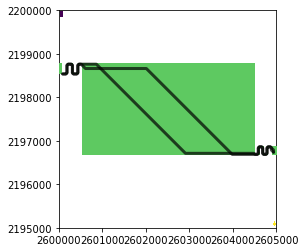

In [2]:
cost_surface_path = os.path.join("data", "synthetic.tif")
source_coord = (2600080, 2198530)
target_coord = (2604933, 2196749)

cost_s_to_t, ls_s_to_t  = calc_least_cost_path(path=cost_surface_path,
                             band=1,
                             source_coord=source_coord, 
                             target_coord=target_coord,
                             matrix=default_lattice)

cost_t_to_s, ls_t_to_s  = calc_least_cost_path(path=cost_surface_path,
                             band=1,
                             source_coord=target_coord, 
                             target_coord=source_coord,
                             matrix=default_lattice)

plot_result([ls_s_to_t, ls_t_to_s], cost_surface=cost_surface_path)

## Aufgabe 2

Bis jetzt haben wir angenommen, dass die Kosten der Kante zwischen zwei Zellen, unabhängig der Richtung, gleich ist. D.h. die Kosten um von Zelle A zu Nachbarzelle B zu kommen, sind die gleichen, wie von Zelle B zu Zelle A. Mit dieser Annahme können wir jedoch nicht alle Probleme lösen.

Zum Beispiel:
* Ein Auto benötigt mehr Energie wenn es aufwärte fährt als wenn es abwärts fährt. D.h. der Energieverbrauch ist abhängig der Fahrtrichtung (und natürlich der Topographie).
* Die maximale Geschwindigkeit eines Segelbotes in eine bestimmte Richtung zu segeln ist nicht nur abhängig von der Windstärke, sondern auch der Windrichtung.

**Überlegen Sie sich, wie Sie den Least Cost Path Algorithmus verändern müssen, um diese Art von Problemen lösen zu können.**

**<span style="color:orange">Man müsste zwei unterschiedliche Kostenoberflächen definieren: Eine für den Hin- und eine für den Rückweg. Anschliessend müsste man den least cost path für beide Kostenoberflächen bestimmen.</span>**

## Aufgabe 3

Bis jetzt haben wir angenommen, dass der least cost path eine kontinuierliche Verbindung von Zellen von Start zu Ziel sein muss. Im Falle von Stromleitungen könnte man aber argumentieren, dass nur die Positionen der Masten relevant sind. Zum Beispiel darf ein Mast nicht auf einer Strasse platziert werden, aber eine Stromleitung darf über eine Strasse führen. Es muss aber ein Minimal-, bzw. Maximalabstand zwischen Masten eingehalten werden. 

**Überlegen Sie sich, wie Sie den Least Cost Path Algorithmus verändern müssen, um diese Art von Problemen lösen zu können.**

**<span style="color:orange">Das ist ein äusserst praxisbezogenes Problem! In diesem Fall müsste man wie gewohnt zuerst eine Kostenoberfläche bestimmen bzw. definieren. Dann müsste ausgehend vom Startpunkt alle Punkte ermitteln, die innerhalb eines bestimmten Distanzbandes liegen (bei Höchstspannungleitungen in der Schweiz werden 300-600 m bevorzugt) und die Kosten für jede Verbindung ermitteln. Anhand der ermittelten Verbindungen und Kosten wird dann ein Graph aufgebaut. Von jedem ermittelten Punkt werden dann wieder die Punkte innerhalb des Distanzbandes und die Verbindungskosten ermittelt. Man kann bereits beim Aufbauen des Graphs "von Punkt zu Punkt" vorgehen und nur die Lösungen in den Graph schreiben, die den Zielpunkt als Endpunkt haben (alle anderen Lösungen werden ignoriert). Unter Umständen kann es nützlich sein, die Anzahl der Iterationen im Voraus zu begrenzen (eine Lösung sehen Sie unten).</span>**

**<span style="color:orange">Anschliessend wird im Graph nach Verbindungen gesucht, die den Start- und den Zielpunkt miteinander verbinden. Für jeden Punkt wird geprüft, ob er sich in einer Zone befindet, in der nicht gebaut werden darf (z.B. ein Moor oder ein Gebäude oder eine Strasse; diese Gebiete müssen in einem separaten File definiert werden). Befindet er sich in einer solchen Zone, wird die Verbindung aus dem Graph gelöscht.</span>**

**<span style="color:orange">Übringens wurde diese Fragestellung in der Praxis wie folgt erweitert: Um die Anzahl an Verbindungen zu reduzieren, wurde zuerst das Azimut vom Start zum Ziel bestimmt. Dann wurde ein Winkel festgelegt, in welchem Punkte miteinander verbunden werden dürfen (in zwei Fällen lag dieser Winkel bei maximal 30°). Dies führte dazu, dass "unpraktische" Azimutänderungen vermieden werden konnten und die Leitung somit begradigt wurde.</span>**